In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('cybersecurity_intrusion_data.csv')
dataset

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9532,SID_09533,194,ICMP,3,226.049889,AES,0.517737,3,Chrome,0,1
9533,SID_09534,380,TCP,3,182.848475,NaN,0.408485,0,Chrome,0,0
9534,SID_09535,664,TCP,5,35.170248,AES,0.359200,1,Firefox,0,0
9535,SID_09536,406,TCP,4,86.664703,AES,0.537417,1,Chrome,1,0


In [2]:
dataset = dataset.drop('protocol_type', axis=1)
dataset = dataset.drop('encryption_used', axis=1)
dataset = dataset.drop('browser_type', axis=1)
dataset = dataset.drop('session_id', axis=1)
dataset

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
0,599,4,492.983263,0.606818,1,0,1
1,472,3,1557.996461,0.301569,0,0,0
2,629,3,75.044262,0.739164,2,0,1
3,804,4,601.248835,0.123267,0,0,1
4,453,5,532.540888,0.054874,1,0,0
...,...,...,...,...,...,...,...
9532,194,3,226.049889,0.517737,3,0,1
9533,380,3,182.848475,0.408485,0,0,0
9534,664,5,35.170248,0.359200,1,0,0
9535,406,4,86.664703,0.537417,1,1,0


In [3]:
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=42)
X_train = df_train.drop('attack_detected', axis=1)
Y_train = df_train['attack_detected']
X_test = df_test.drop('attack_detected', axis=1)
Y_test = df_test['attack_detected']

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from datetime import datetime

class CyberSecurityMLP:
    def __init__(self, hidden_layer_sizes=(100, 50), activation='relu', 
                 solver='adam', alpha=0.0001, learning_rate_init=0.001,
                 max_iter=500, random_state=42, plots_dir='plots'):
        """
        Inizializza il classificatore MLP per cybersecurity
        
        Parameters:
        - hidden_layer_sizes: tuple, dimensioni dei layer nascosti
        - activation: str, funzione di attivazione ('relu', 'tanh', 'logistic')
        - solver: str, algoritmo di ottimizzazione ('adam', 'sgd', 'lbfgs')
        - alpha: float, parametro di regolarizzazione L2
        - learning_rate_init: float, learning rate iniziale
        - max_iter: int, numero massimo di iterazioni
        - random_state: int, seed per riproducibilità
        - plots_dir: str, cartella dove salvare i grafici
        """
        self.mlp = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            random_state=random_state
        )
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = None
        self.plots_dir = plots_dir
        
        # Crea la cartella per i grafici se non esiste
        os.makedirs(self.plots_dir, exist_ok=True)
        print(f"Grafici verranno salvati in: {os.path.abspath(self.plots_dir)}")
        
    def _save_plot(self, filename, dpi=300, bbox_inches='tight'):
        """
        Salva il plot corrente nella cartella specificata
        
        Parameters:
        - filename: str, nome del file (senza estensione)
        - dpi: int, risoluzione dell'immagine
        - bbox_inches: str, come gestire i margini
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filepath = os.path.join(self.plots_dir, f"{filename}_{timestamp}.png")
        plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
        print(f"Grafico salvato: {filepath}")
        
    def preprocess_data(self, X, y=None, fit_transform=True):
        """
        Preprocessa i dati: scaling delle features e encoding delle label
        
        Parameters:
        - X: DataFrame o array, features
        - y: Series o array, target (opzionale per predict)
        - fit_transform: bool, se True fit e transform, altrimenti solo transform
        
        Returns:
        - X_scaled: array, features scalate
        - y_encoded: array, target encodate (se y è fornito)
        """
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
            
        if fit_transform:
            X_scaled = self.scaler.fit_transform(X)
            if y is not None:
                y_encoded = self.label_encoder.fit_transform(y)
                return X_scaled, y_encoded
        else:
            X_scaled = self.scaler.transform(X)
            if y is not None:
                y_encoded = self.label_encoder.transform(y)
                return X_scaled, y_encoded
                
        return X_scaled
    
    def train(self, X_train, y_train, validation_split=0.2):
        """
        Addestra il modello MLP
        
        Parameters:
        - X_train: DataFrame o array, features di training
        - y_train: Series o array, target di training
        - validation_split: float, percentuale per validation set
        """
        # Preprocessing
        X_scaled, y_encoded = self.preprocess_data(X_train, y_train, fit_transform=True)
        
        # Split per validation
        if validation_split > 0:
            X_tr, X_val, y_tr, y_val = train_test_split(
                X_scaled, y_encoded, test_size=validation_split, 
                random_state=42, stratify=y_encoded
            )
            
            # Training
            self.mlp.fit(X_tr, y_tr)
            
            # Valutazione su validation set
            val_score = self.mlp.score(X_val, y_val)
            print(f"Validation Accuracy: {val_score:.4f}")
            
            # Predizioni per validation
            y_val_pred = self.mlp.predict(X_val)
            y_val_proba = self.mlp.predict_proba(X_val)[:, 1]
            
            print("\nValidation Classification Report:")
            print(classification_report(y_val, y_val_pred, 
                                      target_names=['Honest', 'Attacker']))
            
            auc_score = roc_auc_score(y_val, y_val_proba)
            print(f"Validation AUC Score: {auc_score:.4f}")
            
            # Salva confusion matrix per validation
            self._plot_validation_confusion_matrix(y_val, y_val_pred)
            
        else:
            # Training su tutto il dataset
            self.mlp.fit(X_scaled, y_encoded)
            
        print(f"Training completed. Final loss: {self.mlp.loss_:.4f}")
        
        # Salva curva di training se disponibile
        self.plot_training_curve()
    
    def _plot_validation_confusion_matrix(self, y_true, y_pred):
        """
        Crea e salva confusion matrix per validation set
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Honest', 'Attacker'], 
                   yticklabels=['Honest', 'Attacker'])
        plt.title('Validation Set - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        self._save_plot('validation_confusion_matrix')
        plt.show()
    
    def predict(self, X_test):
        """
        Effettua predizioni sui dati di test
        
        Parameters:
        - X_test: DataFrame o array, features di test
        
        Returns:
        - predictions: array, predizioni binarie
        - probabilities: array, probabilità di essere attaccante
        """
        X_scaled = self.preprocess_data(X_test, fit_transform=False)
        predictions = self.mlp.predict(X_scaled)
        probabilities = self.mlp.predict_proba(X_scaled)[:, 1]
        
        # Decodifica le predizioni
        predictions_decoded = self.label_encoder.inverse_transform(predictions)
        
        return predictions_decoded, probabilities
    
    def evaluate(self, X_test, y_test):
        """
        Valuta le performance del modello su test set
        
        Parameters:
        - X_test: DataFrame o array, features di test
        - y_test: Series o array, target di test
        """
        predictions, probabilities = self.predict(X_test)
        
        # Encoding del target per le metriche
        y_test_encoded = self.label_encoder.transform(y_test)
        predictions_encoded = self.label_encoder.transform(predictions)
        
        # Metriche
        accuracy = self.mlp.score(self.scaler.transform(X_test), y_test_encoded)
        auc_score = roc_auc_score(y_test_encoded, probabilities)
        
        print("=== TEST SET EVALUATION ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        print(f"Number of test samples: {len(y_test)}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, predictions, 
                                  target_names=['Honest', 'Attacker']))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test_encoded, predictions_encoded)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Honest', 'Attacker'], 
                   yticklabels=['Honest', 'Attacker'])
        plt.title('Test Set - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        self._save_plot('test_confusion_matrix')
        plt.show()
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test_encoded, probabilities)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, 
                label=f'ROC Curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Test Set')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        self._save_plot('test_roc_curve')
        plt.show()
        
        return accuracy, auc_score
    
    def plot_training_curve(self):
        """
        Visualizza la curva di loss durante il training
        """
        if hasattr(self.mlp, 'loss_curve_'):
            plt.figure(figsize=(10, 6))
            plt.plot(self.mlp.loss_curve_, 'b-', linewidth=2)
            plt.title('Training Loss Curve')
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.grid(True, alpha=0.3)
            
            # Aggiungi informazioni finali
            final_loss = self.mlp.loss_curve_[-1]
            plt.text(0.7, 0.9, f'Final Loss: {final_loss:.4f}', 
                    transform=plt.gca().transAxes, 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            self._save_plot('training_loss_curve')
            plt.show()
        else:
            print("Loss curve not available. Set validation_fraction > 0 during training.")
    
    def get_feature_importance(self, X_sample, plot=True):
        """
        Calcola l'importance approssimata delle features usando permutation importance
        
        Parameters:
        - X_sample: DataFrame, campione rappresentativo del dataset
        - plot: bool, se True crea e salva il grafico dell'importance
        
        Returns:
        - feature_importance: dict, importance per feature
        """
        if self.feature_names is None:
            print("Feature names not available")
            return None
            
        X_scaled = self.scaler.transform(X_sample)
        baseline_pred = self.mlp.predict_proba(X_scaled)[:, 1].mean()
        
        importance_scores = {}
        
        print("Calcolando feature importance...")
        for i, feature_name in enumerate(self.feature_names):
            # Permuta la feature
            X_permuted = X_scaled.copy()
            np.random.shuffle(X_permuted[:, i])
            
            # Calcola la predizione con feature permutata
            permuted_pred = self.mlp.predict_proba(X_permuted)[:, 1].mean()
            
            # Importance = differenza nelle predizioni
            importance_scores[feature_name] = abs(baseline_pred - permuted_pred)
        
        # Ordina per importance
        sorted_importance = dict(sorted(importance_scores.items(), 
                                      key=lambda x: x[1], reverse=True))
        
        if plot:
            self._plot_feature_importance(sorted_importance)
        
        return sorted_importance
    
    def _plot_feature_importance(self, importance_dict, top_n=15):
        """
        Crea e salva il grafico dell'importance delle feature
        
        Parameters:
        - importance_dict: dict, importance per feature
        - top_n: int, numero di top feature da mostrare
        """
        # Prendi le top N feature
        top_features = dict(list(importance_dict.items())[:top_n])
        
        features = list(top_features.keys())
        importance_values = list(top_features.values())
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(range(len(features)), importance_values, color='skyblue', alpha=0.8)
        
        # Personalizzazione
        plt.yticks(range(len(features)), features)
        plt.xlabel('Permutation Importance Score')
        plt.title(f'Top {top_n} Feature Importance (Permutation Method)')
        plt.grid(axis='x', alpha=0.3)
        
        # Aggiungi valori sulle barre
        for i, (bar, value) in enumerate(zip(bars, importance_values)):
            plt.text(value + max(importance_values) * 0.01, i, f'{value:.4f}', 
                    va='center', fontsize=9)
        
        plt.tight_layout()
        self._save_plot('feature_importance')
        plt.show()
    
    def plot_prediction_distribution(self, X_test, y_test):
        """
        Visualizza la distribuzione delle probabilità di predizione
        
        Parameters:
        - X_test: DataFrame o array, features di test
        - y_test: Series o array, target di test
        """
        _, probabilities = self.predict(X_test)
        
        plt.figure(figsize=(10, 6))
        
        # Separare le probabilità per classe reale
        honest_probs = probabilities[y_test == 'Honest']
        attacker_probs = probabilities[y_test == 'Attacker']
        
        # Istogrammi
        plt.hist(honest_probs, bins=50, alpha=0.7, label='Honest (Real)', 
                color='green', density=True)
        plt.hist(attacker_probs, bins=50, alpha=0.7, label='Attacker (Real)', 
                color='red', density=True)
        
        # Linea di soglia (0.5)
        plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, 
                   label='Decision Threshold')
        
        plt.xlabel('Predicted Probability (Attacker)')
        plt.ylabel('Density')
        plt.title('Distribution of Prediction Probabilities by True Class')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        self._save_plot('prediction_distribution')
        plt.show()
    
    def create_performance_summary(self, X_test, y_test):
        """
        Crea un grafico riassuntivo delle performance
        
        Parameters:
        - X_test: DataFrame o array, features di test
        - y_test: Series o array, target di test
        """
        predictions, probabilities = self.predict(X_test)
        y_test_encoded = self.label_encoder.transform(y_test)
        predictions_encoded = self.label_encoder.transform(predictions)
        
        # Calcola metriche
        from sklearn.metrics import precision_score, recall_score, f1_score
        accuracy = self.mlp.score(self.scaler.transform(X_test), y_test_encoded)
        precision = precision_score(y_test_encoded, predictions_encoded)
        recall = recall_score(y_test_encoded, predictions_encoded)
        f1 = f1_score(y_test_encoded, predictions_encoded)
        auc = roc_auc_score(y_test_encoded, probabilities)
        
        # Crea grafico
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
        values = [accuracy, precision, recall, f1, auc]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 
                                              'gold', 'plum'], alpha=0.8)
        
        # Aggiungi valori sulle barre
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.ylim(0, 1.1)
        plt.ylabel('Score')
        plt.title('Model Performance Summary - Test Set')
        plt.grid(axis='y', alpha=0.3)
        
        self._save_plot('performance_summary')
        plt.show()
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_roc': auc
        }

Validation Accuracy: 0.8290

Validation Classification Report:
              precision    recall  f1-score   support

      Honest       0.84      0.86      0.85       846
    Attacker       0.82      0.79      0.80       680

    accuracy                           0.83      1526
   macro avg       0.83      0.83      0.83      1526
weighted avg       0.83      0.83      0.83      1526

Validation AUC Score: 0.8770
Training completed. Final loss: 0.1873
=== TEST SET EVALUATION ===
Accuracy: 0.8124
AUC Score: 0.8657
Number of test samples: 1908

Classification Report:
              precision    recall  f1-score   support

      Honest       0.82      0.85      0.83      1042
    Attacker       0.81      0.77      0.79       866

    accuracy                           0.81      1908
   macro avg       0.81      0.81      0.81      1908
weighted avg       0.81      0.81      0.81      1908



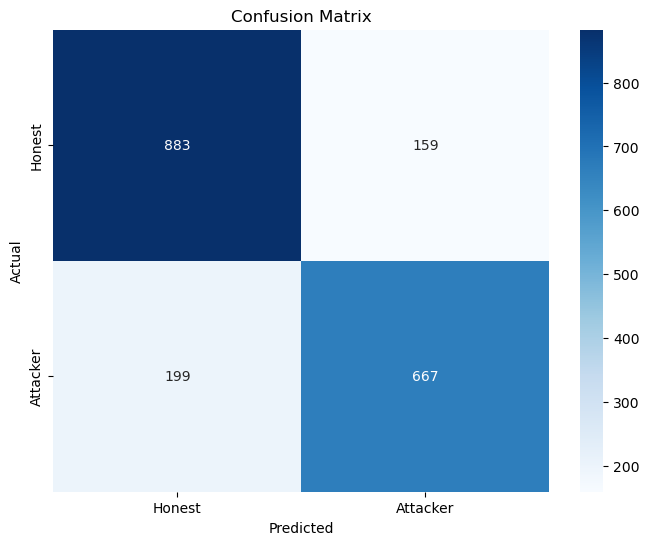

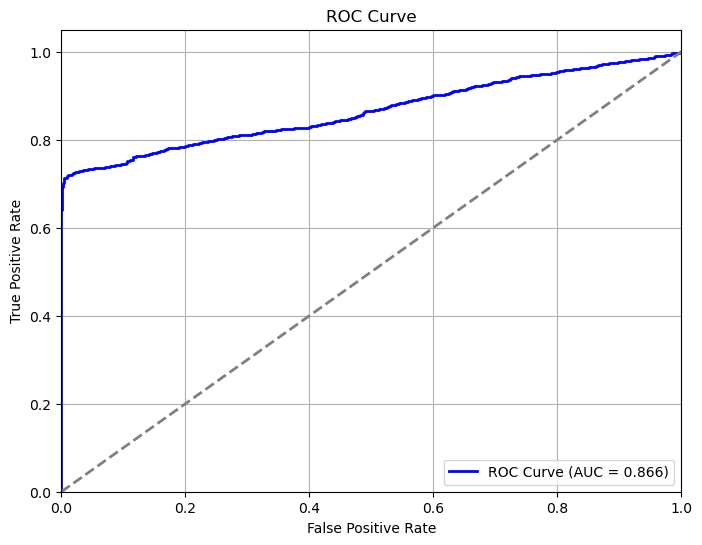

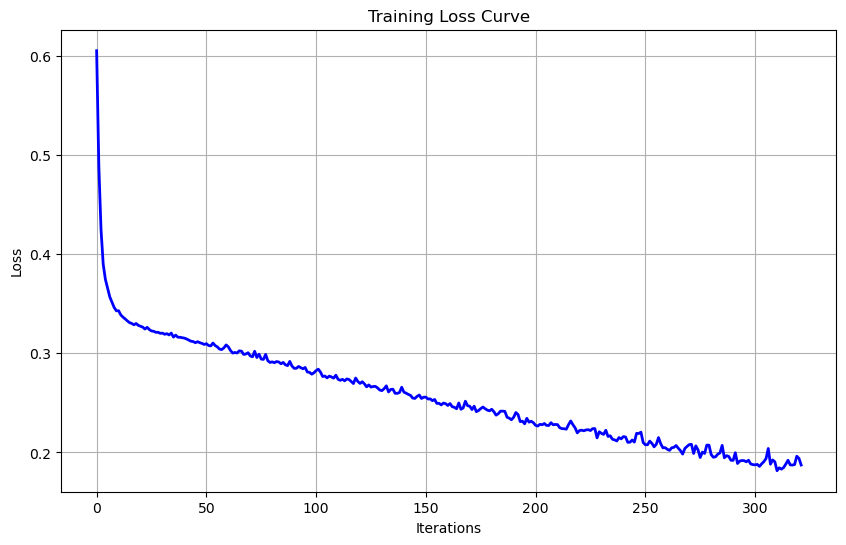

{'ip_reputation_score': 0.004095208211025547,
 'unusual_time_access': 0.0023959450757154444,
 'login_attempts': 0.002249410094712301,
 'network_packet_size': 0.0020908540353265503,
 'failed_logins': 0.0009773857691373622,
 'session_duration': 0.0007264446219900633}

In [5]:
mlp_model = CyberSecurityMLP(
    hidden_layer_sizes=(128, 64, 32),  
    activation='relu',
    alpha=0.001,
    max_iter=500
)


mlp_model.train(X_train, Y_train)
mlp_model.evaluate(X_test, Y_test)
mlp_model.plot_training_curve()
mlp_model.get_feature_importance(X_train)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import numpy as np

class MLPTuner:
    def __init__(self, X_train, y_train, cv_folds=5):
        self.X_train = X_train
        self.y_train = y_train
        self.cv_folds = cv_folds
        self.best_params = None
        
    def quick_tune(self):
        """
        Tuning rapido con parametri essenziali
        """
        param_grid = {
            'hidden_layer_sizes': [
                (50,), (100,), (150,),
                (50, 25), (100, 50), (150, 75)
            ],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'sgd', 'lbfgs'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01]
        }
        
        mlp = MLPClassifier(max_iter=1000, random_state=42)
        
        grid_search = GridSearchCV(
            mlp, param_grid, cv=self.cv_folds, 
            scoring='roc_auc', n_jobs=-1, verbose=1
        )
        
        grid_search.fit(self.X_train, self.y_train)
        self.best_params = grid_search.best_params_
        
        print("=== QUICK TUNING RESULTS ===")
        print(f"Best parameters: {self.best_params}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_

# Esempio di utilizzo
def tune_cybersecurity_mlp(X_train, y_train):
    """
    Funzione specifica per tuning MLP cybersecurity
    """
    tuner = MLPTuner(X_train, y_train)
    
    # Analisi dataset
    n_samples, n_features = X_train.shape
    tuner.dataset_size_recommendations(n_samples, n_features)
    
    print("\n" + "="*50)
    print("Starting parameter tuning...")
    
    # Tuning rapido prima
    best_model_quick = tuner.quick_tune()
    
    return best_model_quick

In [8]:
tune_cybersecurity_mlp(X_train, Y_train) 

Dataset: 7629 samples, 6 features
MEDIUM DATASET - Raccomandazioni:
- hidden_layer_sizes: (100, 50) o (150, 75)
- solver: 'adam'
- alpha: 0.0001-0.001
- learning_rate_init: 0.001
- max_iter: 1000
- Neuroni consigliati per primo layer: ~5

Starting parameter tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
=== QUICK TUNING RESULTS ===
Best parameters: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (50, 25), 'learning_rate_init': 0.001, 'solver': 'adam'}
Best CV score: 0.7862


MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 25),
              max_iter=1000, random_state=42)

Grafici verranno salvati in: c:\Users\Jonas\Desktop\Magistrale\Primo Anno\Secondo Semestre\Machine Learning\Progetto\plots
Validation Accuracy: 0.8781

Validation Classification Report:
              precision    recall  f1-score   support

      Honest       0.82      0.99      0.90       846
    Attacker       0.99      0.74      0.84       680

    accuracy                           0.88      1526
   macro avg       0.91      0.86      0.87      1526
weighted avg       0.90      0.88      0.87      1526

Validation AUC Score: 0.8722
Grafico salvato: plots\validation_confusion_matrix_20250702_120757.png


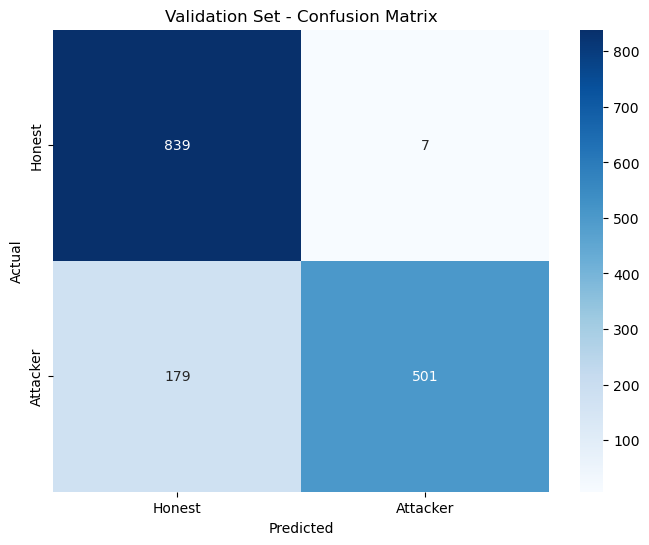

Training completed. Final loss: 0.3370
Grafico salvato: plots\training_loss_curve_20250702_120757.png


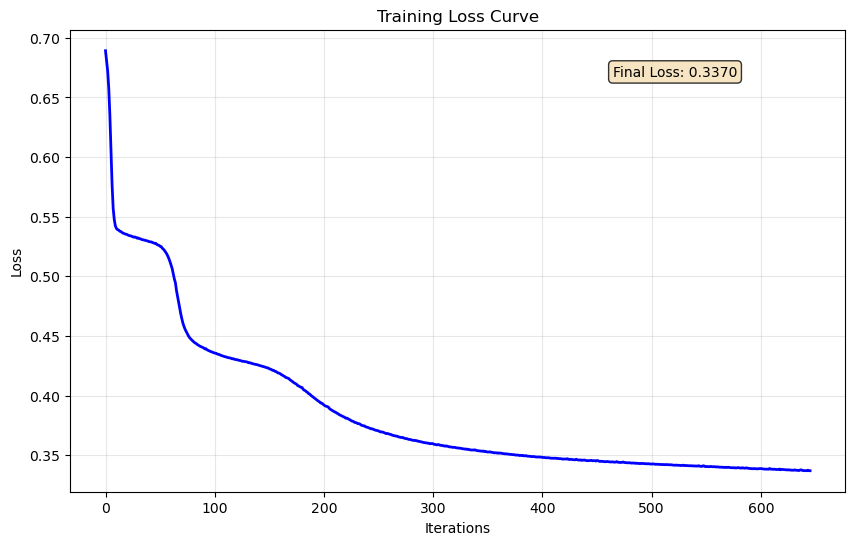

=== TEST SET EVALUATION ===
Accuracy: 0.8643
AUC Score: 0.8605
Number of test samples: 1908

Classification Report:
              precision    recall  f1-score   support

      Honest       0.80      0.99      0.89      1042
    Attacker       0.99      0.71      0.83       866

    accuracy                           0.86      1908
   macro avg       0.90      0.85      0.86      1908
weighted avg       0.89      0.86      0.86      1908

Grafico salvato: plots\test_confusion_matrix_20250702_120758.png


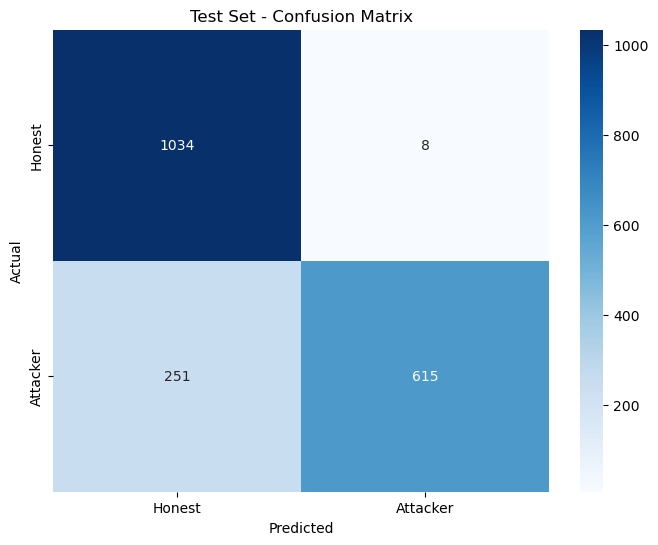

Grafico salvato: plots\test_roc_curve_20250702_120758.png


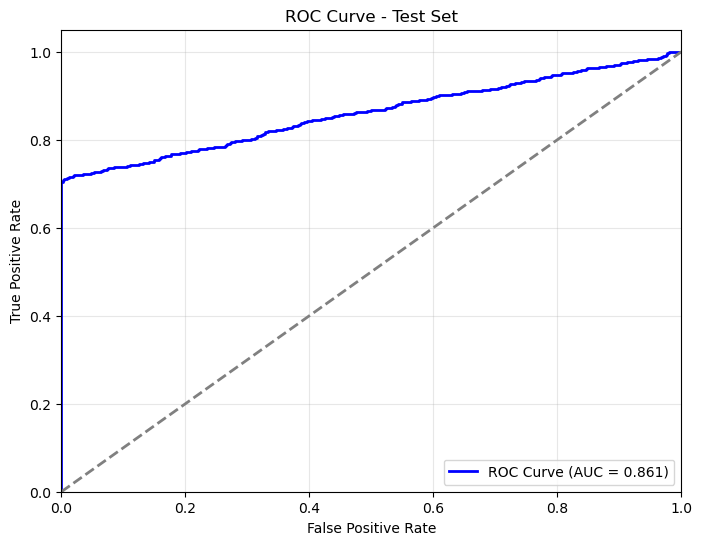

Calcolando feature importance...
Grafico salvato: plots\feature_importance_20250702_120759.png


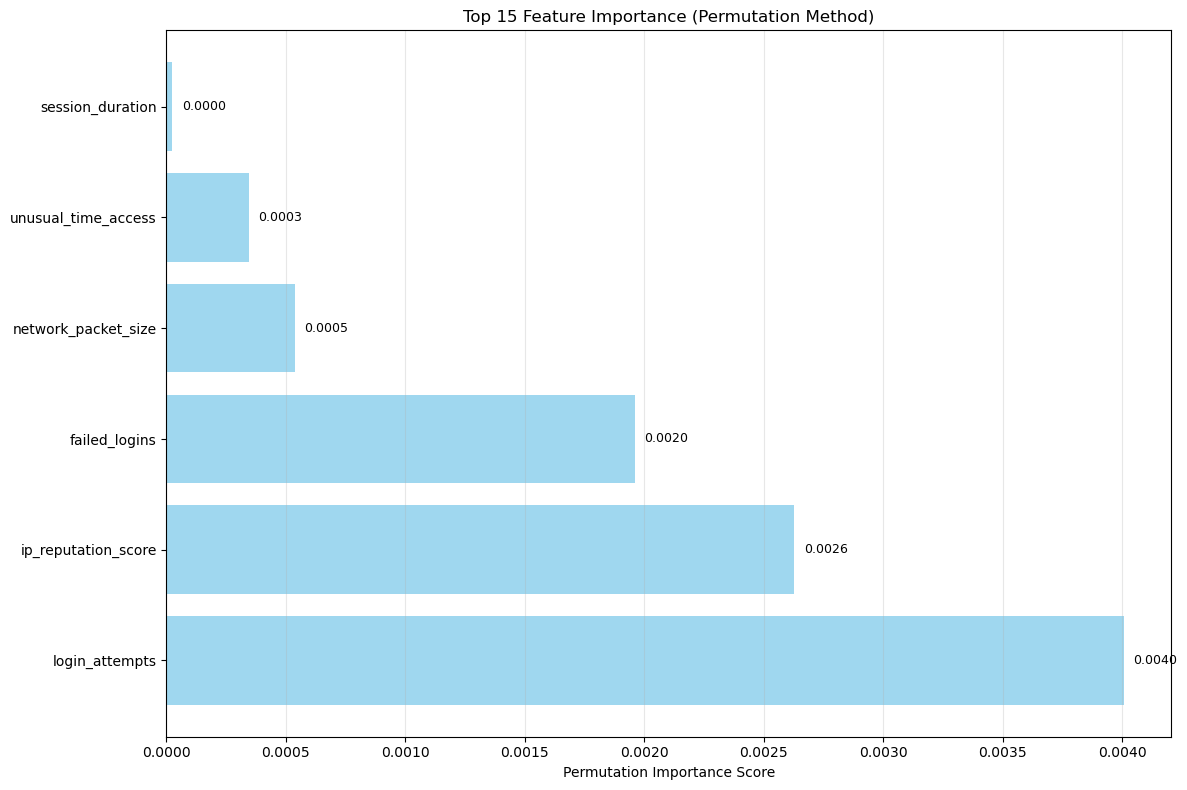

c:\Users\Jonas\anaconda3\Lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Grafico salvato: plots\prediction_distribution_20250702_120800.png


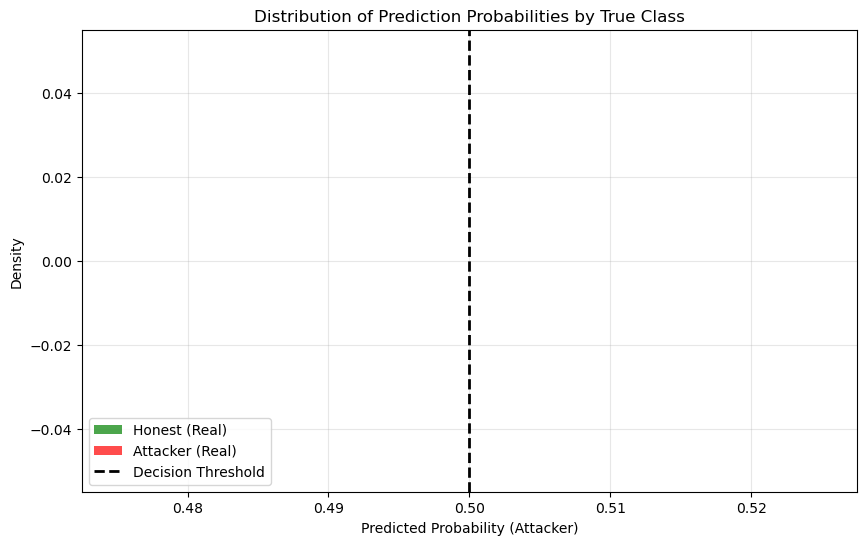

Grafico salvato: plots\performance_summary_20250702_120801.png


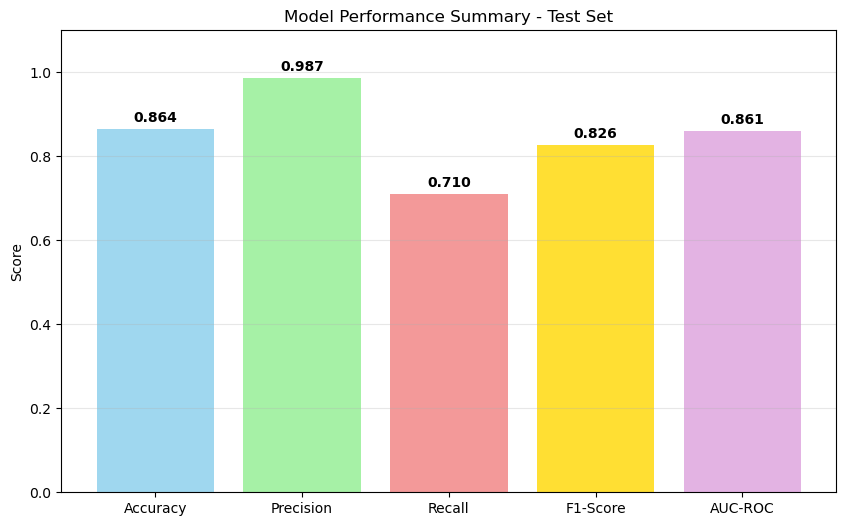

In [5]:
mlp_model = CyberSecurityMLP(
    hidden_layer_sizes=(50, 25),  
    activation='logistic',
    alpha=0.001,
    max_iter=1000,
    learning_rate_init=0.001
)


mlp_model.train(X_train, Y_train)
mlp_model.evaluate(X_test, Y_test)
importance = mlp_model.get_feature_importance(X_test)
mlp_model.plot_prediction_distribution(X_test, Y_test)
metrics = mlp_model.create_performance_summary(X_test, Y_test)

In [7]:
# Dopo aver addestrato il modello
import joblib

# Salva il modello
joblib.dump(mlp_model, 'cybersecurity_mlp_model.joblib')

# Opzionale: salva anche informazioni sulle features
import json
metadata = {
    'feature_names': list(X_train.columns),  # o i nomi delle tue features
    'n_features': X_train.shape[1],
    'model_version': '1.0'
}
with open('cybersecurity_mlp_metadata.json', 'w') as f:
    json.dump(metadata, f)